# RAG pipeline
### there is a retrieval step and then an augmentation step and then a generation step

- retrieval step getting a query embedding, passing it to a retriever, getting a list of documents
- augmentation step, change the prompt with the contents of the document and the question, 
- and then the generation step to get an answer

happens different ways
### embedding retrieval or semantic search - compare to all documents in a database and compare for semantic similarity
this is that pipeline: 
- embedder for the query
- embedding retriever
- prompt builder
- generator
### other rag
- keyword
- retrieval + reranking
- retrieval from another api

### indexing and RAG pipelines
- clean, split and embed documents into a vector database
- in the lab the source will be the web, fetching url content, converting and embedding them




- 



In [78]:
import os
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [62]:
%pip uninstall -r requirements.txt -y

Found existing installation: lxml 5.3.0
Uninstalling lxml-5.3.0:
  Successfully uninstalled lxml-5.3.0
Note: you may need to restart the kernel to use updated packages.


In [77]:
# %pip install "lxml[html_clean]"
# %pip uninstall -r requirements.txt -y
%pip uninstall lxml -y
%pip uninstall trafilatura -y
%pip install -r requirements.txt --upgrade
# %pip install -r requirements.txt --upgrade
# %pip install "lxml[html_clean]==5.1.0"
# %pip install trafilatura==1.6.3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached haystack_ai-2.2.4-py3-none-any.whl (346 kB)
  Using cached haystack_experimental-0.1.0-py3-none-any.whl (40 kB)
  Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
  Using cached transformers-4.42.3-py3-none-any.whl (9.3 MB)
  Using cached gradio-4.37.2-py3-none-any.whl (12.3 MB)
  Using cached huggingface_hub-0.23.4-py3-none-any.whl (402 kB)
  Using cached cohere_haystack-1.1.3-py3-none-any.whl (20 kB)
  Using cached newspaper3k-0.2.8-py3-none-any.whl (211 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached lxml-5.3.0-cp310-cp310-macosx_10_9_universal2.whl (8.1 MB)

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


the reason for all the imports is becxause we will be building a lot of pipelines
one important change is using cohere for embeddings of text and documents

there are haystack integrations to support this 

In [91]:
from bs4 import BeautifulSoup
from haystack import component
from haystack.dataclasses import Document, ByteStream
from typing import List, Dict, Any

@component
class BeautifulSoupToDocument:
    @component.output_types(documents=List[Document])
    def run(self, streams: List[ByteStream]):
        documents = []
        for stream in streams:
            soup = BeautifulSoup(stream.data, "html.parser")
            text = soup.get_text(separator="\n", strip=True)
            document = Document(content=text, meta=stream.meta)
            documents.append(document)
        return {"documents": documents}
    
    

In [92]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
# from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

- will be using a link content fetcher to get the content from the web
- won't be splitting beacues the documents are short

In [88]:
%pip freeze

aiofiles==23.2.1
altair==5.4.1
annotated-types==0.7.0
anyio==4.4.0
appnope==0.1.4
asttokens==2.4.1
attrs==24.2.0
babel==2.16.0
backoff==2.2.1
beautifulsoup4==4.12.3
boto3==1.35.14
botocore==1.35.14
certifi==2024.8.30
charset-normalizer==3.3.2
click==8.1.7
cohere==5.9.1
cohere-haystack==1.1.3
colorama==0.4.6
comm==0.2.2
contourpy==1.3.0
courlan==1.3.1
cssselect==1.2.0
cycler==0.12.1
dateparser==1.2.0
debugpy==1.8.5
decorator==5.1.1
distro==1.9.0
exceptiongroup==1.2.2
executing==2.1.0
fastapi==0.114.0
fastavro==1.9.7
feedfinder2==0.0.4
feedparser==6.0.11
ffmpy==0.4.0
filelock==3.16.0
fonttools==4.53.1
fsspec==2024.9.0
gradio==4.37.2
gradio_client==1.0.2
h11==0.14.0
haystack-ai==2.2.4
haystack-experimental==0.1.0
htmldate==1.9.0
httpcore==1.0.5
httpx==0.27.2
httpx-sse==0.4.0
huggingface-hub==0.23.4
idna==3.8
importlib_resources==6.4.4
ipykernel==6.29.5
ipython==8.27.0
jedi==0.19.1
jieba3k==0.35.1
Jinja2==3.1.4
jiter==0.5.0
jmespath==1.0.1
joblib==1.4.2
jsonschema==4.23.0
jsonschema-specif

In [89]:
# %pip freeze | grep -E "lxml|trafilatura"

In [93]:
# Now, let's set up the pipeline
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = BeautifulSoupToDocument()
embedder = CohereDocumentEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.streams")
indexing.connect("converter.documents", "embedder.documents")
indexing.connect("embedder.documents", "writer.documents")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: BeautifulSoupToDocument
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.streams (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

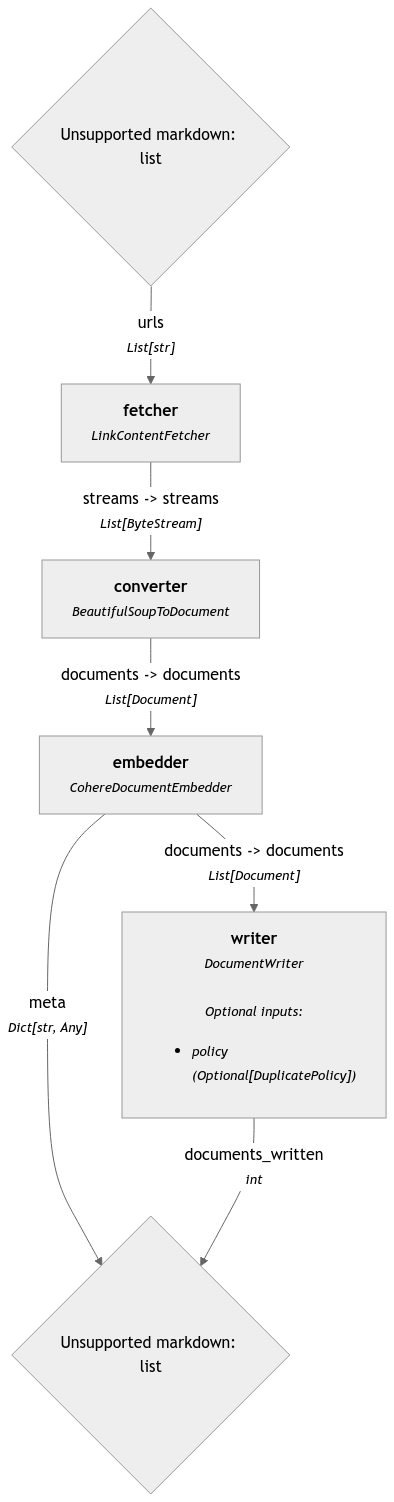

In [94]:
indexing.show()